In [1]:
#basic/utility imports
import json
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_nlp

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


In [2]:
def random_instance_generator():
    imgs_base_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
    caps_base_dir = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
    images = os.listdir(imgs_base_dir)
    with open(caps_base_dir,'r') as file:
        captions = json.load(file)
    instance_n = random.randint(0,len(images))
    img_id = int(images[instance_n].split('.')[0])
    
    img = cv2.imread(imgs_base_dir + '/' + images[instance_n])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img);plt.axis(False);plt.show()
    
    annotations = captions['annotations']
    
    print('The above image has following captions :: \n\n')
    for i in annotations:
        if i['image_id'] == img_id:
            print(i['caption'])

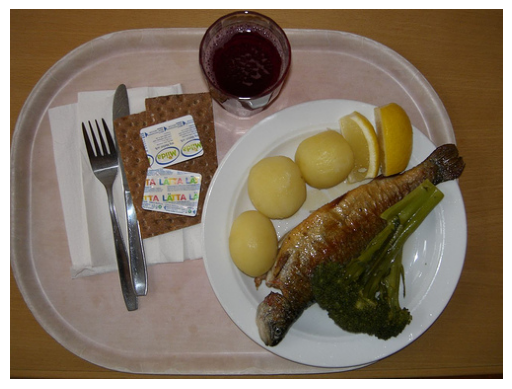

The above image has following captions :: 


A tray topped with a plate of fish next to a glass with a red liquid.
A photo of a plate of fish and potatoes.
The dinner has a plate of fish and potatoes.
A whole fish, a large stalk of broccoli, and some lemon slices are on a plate.
a plate with a fish, lemons, potatoes, and some crackers on it 


In [3]:
random_instance_generator()

In [4]:
with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json','r') as file:
    captions = json.load(file)

caption_corpus = ['<sos> '+ i['caption'] + ' <eos>' for i in captions['annotations']]

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(caption_corpus)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [5]:
dataset = []
val_dataset = []

img_base_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
images = os.listdir(img_base_dir)
with open ('/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json','r') as file : captions = json.load(file)
ann = captions['annotations']

img_captions = {}

for i in ann:
    if i['image_id'] not in img_captions:
        img_captions[i['image_id']] = ['<sos> '+ i['caption'] + ' <eos>']
    else:
        img_captions[i['image_id']].append('<sos> '+ i['caption'] + ' <eos>')
        
for i in images[:20000]:
    img_id = int(i.split('.')[0])
    img = img_base_dir + '/' + i
    try:
        for j in img_captions[img_id]:
            dataset.append((img,j))
    except:
        pass

In [6]:
def dataset_generator():
    for datapoint in dataset:
        img_path,cap = datapoint
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(512,512),cv2.INTER_LINEAR)
        img = img / 255
        
        cap_token = tokenizer.texts_to_sequences([cap])
        cap_token = cap_token[0]
        
        yield (img,cap_token)



In [7]:
tfds = tf.data.Dataset.from_generator(dataset_generator,output_types=(tf.float32,tf.int16))
tfds = tfds.padded_batch(16,padded_shapes=((512,512,3),[None]))

In [8]:
class ImageCaptionModel(tf.keras.Model):
    
    def __init__(self, vocab_sz, emb_sz=512):
        super().__init__()
        resnet = tf.keras.applications.ResNet50V2(include_top=False,weights='imagenet')
        resnet.trainable = False

        self.feature_extractor = tf.keras.Sequential([resnet,
                                                      tf.keras.layers.Conv2D(512,(1,1)),
                                                      tf.keras.layers.Reshape((-1,512))])
        
        self.encoder = keras_nlp.layers.TransformerEncoder(intermediate_dim=emb_sz,num_heads=8)
        
        self.embedding = tf.keras.layers.Embedding(vocab_sz,emb_sz)
        
        self.decoder = keras_nlp.layers.TransformerDecoder(intermediate_dim=emb_sz,num_heads=8)
        
        self.forward = tf.keras.layers.Dense(vocab_sz,activation='softmax')
        
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        
    
    def calculate_loss(self,img_features,captions):
        
        encoder_output = self.encoder(inputs=img_features)
        
        y_input = captions[:,:-1]
        y_true = captions[:,1:]
        
        padding_mask = (y_input != 0)
        
        input_shape = tf.shape(y_input)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        
        attention_mask = tf.linalg.LinearOperatorLowerTriangular(tf.ones(shape=(batch_size, sequence_length, sequence_length))).to_dense()
        
        y_input_embedding = self.embedding(y_input)
        
        decoder_output = self.decoder(decoder_sequence=y_input_embedding,
                                      encoder_sequence=encoder_output,
                                      decoder_padding_mask=padding_mask,
                                      decoder_attention_mask=attention_mask)
        
        vocab_mapping = self.forward(decoder_output)
        
        loss = self.loss(y_true,vocab_mapping)
        padding_adjustment = loss * tf.cast(padding_mask,dtype=loss.dtype)
        actual_loss = tf.reduce_mean(padding_adjustment) / tf.reduce_mean(tf.cast(padding_mask,dtype=loss.dtype))
        
        return loss
        
    def train_step(self,batch):
        imgs,captions = batch
        
        img_features = self.feature_extractor(imgs)
        with tf.GradientTape() as tape:
            loss = self.calculate_loss(img_features, captions)
    
        train_vars = (
            self.feature_extractor.trainable_variables +
            self.encoder.trainable_variables + 
            self.embedding.trainable_variables +
            self.decoder.trainable_variables +
            self.forward.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    def call(self,img,pred_len=20):
        
        img_feature = self.feature_extractor(np.expand_dims(img,0))
        
        encoder_output = self.encoder(img_feature)
        output = []
        padding_mask = np.ones((1,pred_len))
        attention_mask = np.tril(np.ones((1,pred_len,pred_len)))
        
        decoder_sequence = np.ones((1,pred_len)) * 2
        
        for i in range(pred_len-1):
            dseq_em = self.embedding(decoder_sequence)
            decoder_output = self.decoder(decoder_sequence=dseq_em,
                                      encoder_sequence=encoder_output,
                                      decoder_padding_mask=padding_mask,
                                      decoder_attention_mask=attention_mask)
            mapping = self.forward(decoder_output)
            o = tf.argmax(mapping,2)
            output.append(o[0,i+1].numpy())
            decoder_sequence[0,i+1] = o[0,i+1].numpy()
        
        return output

In [9]:
vocab_sz = len(tokenizer.word_index)
image_captioner = ImageCaptionModel(vocab_sz=vocab_sz)

94668760/94668760 [==============================] - 0s 0us/step


In [10]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="none")

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='cp.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)

opt = tf.keras.optimizers.Adam()

image_captioner.compile(
    optimizer=opt,
    loss=cross_entropy
)

In [11]:
image_captioner.load_weights('/kaggle/input/weights-around-1-3loss/cp.ckpt')

In [ ]:
history = image_captioner.fit(
    tfds,
    epochs=7,
    callbacks=[early_stopping,cp_callback]
)

In [14]:
kk = (iter(tfds))

a a kitchen stove and refrigerator sink with and in cupboards oven microwave eos <pad> <pad> <pad> <pad> <pad>


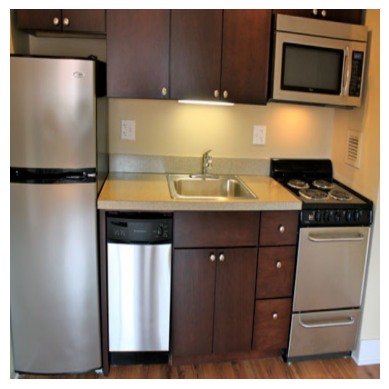

In [51]:
imgs,_ = next(kk)
print(tokenizer.sequences_to_texts([image_captioner(imgs.numpy()[9])])[0])
plt.imshow(imgs.numpy()[9]);plt.axis(False)
plt.show()